In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import keras
import os
import sys

from PIL import Image
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import audioFeatureExtraction

sys.path.append('..')
import data
import model
import preprocessing
import utils

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.
C:\Users\PC\Anaconda3\envs\TensorFlow-GPU-Keras\lib\site-packages\pydub\utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
params = utils.yaml_to_dict('config.yml')

## Construir el nuevo conjunto de datos

Este dataset contiene el Espectograma de la palabra completa, osea que no se le aplica el proceso de separación por ventanas

In [14]:
def save_img(spectogram,specgram_folder,file):
    
    if not os.path.exists(specgram_folder):
        os.makedirs(specgram_folder)
      
    fpath = os.path.join(specgram_folder, file)
    im = Image.fromarray(spectogram,'L')
    im.save(fpath)

def generate_spectogram_images(params):
    
    shape_list = list()
    
    audios_path = os.path.join(params['data_dir'],params['data_dir_audios'])
    
    for root, dirs, files in os.walk(audios_path, topdown=False):
        for name in files:
            
            specgram_folder = os.path.join(params['data_dir'],params['data_dir_images']+'_test',root.split(os.path.sep)[-1])
        
            [fs, x] = audioBasicIO.readAudioFile(os.path.join(root, name))
            x = audioBasicIO.stereo2mono(x)
            x = preprocessing._rescaled_signal(x)
            
            segments = preprocessing._find_segments_from_audio(x=x, fs=fs)
            
            for i,segment in enumerate(segments):
                
                imname = 'specgram_matrix_' + os.path.splitext(name)[0] + '_segment' + str(i) + '.png'
                audio_fragment = preprocessing._extract_audio_fragments(x=x, fs=fs, segment=segment)

                specgram, TimeAxis, FreqAxis = audioFeatureExtraction.stSpectogram(
                    audio_fragment,
                    fs,
                    round(fs * 0.02),
                    round(fs * 0.01),
                    False)
                
                shape_list.append(specgram.shape)
            
                save_img(specgram,specgram_folder,imname)
                
    return shape_list

In [15]:
s_list = generate_spectogram_images(params)
w, h = np.mean(s_list, axis=0)

In [18]:
#w = int(w)
#h = int(h)
w = 110
h = 480

In [5]:
params['data_dir_images'] = 'images_test'
preprocessing.split_data(params)

## Instanciar el modelo

In [72]:
inputs = tf.keras.layers.Input(shape=(w, h, 3))
net = model.ModelArchitecture(num_classes=params['num_classes'])
x = net(inputs, training=False)
net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 55, 240, 64)       9472      
_________________________________________________________________
batch_normalization_5 (Batch (None, 55, 240, 64)       256       
_________________________________________________________________
activation_10 (Activation)   (None, 55, 240, 64)       0         
_________________________________________________________________
global_average_pooling2d_5 ( (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                650       
_________________________________________________________________
activation_11 (Activation)   (None, 10)                0         
Total params: 10,378
Trainable params: 10,250
Non-trainable params: 128
_________________________________________________________________


## Crear el generador

In [23]:
def mk_datagenerator(params,mode):  
    
    data_path = os.path.join(params['data_dir'],params['data_dir_images'],mode)

    datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    
    train_generator = datagen.flow_from_directory(
        data_path,
        target_size=(w,h),
        batch_size=params['batch_size'],
        class_mode='categorical')
    
    return train_generator

In [74]:
print('Data in train')
train_generator = mk_datagenerator(params)
"""
print('Data in validation')
train_generator = data.make_datagenerator(params,mode='training')
print('Data in validation')
val_generator = data.make_datagenerator(params,mode='validation')
"""

Data in train
Found 3050 images belonging to 10 classes.


"\nprint('Data in validation')\ntrain_generator = data.make_datagenerator(params,mode='training')\nprint('Data in validation')\nval_generator = data.make_datagenerator(params,mode='validation')\n"

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

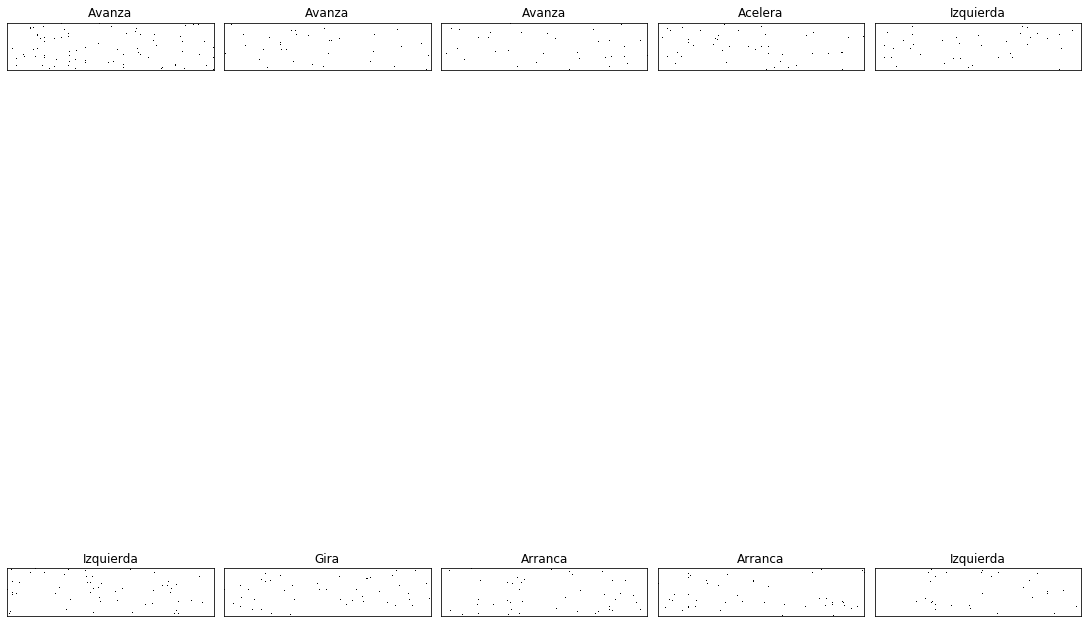

In [75]:
label_id_map = preprocessing._load_label_id_map(params)
label_map = {v:k for (k, v) in label_id_map.items()}

fig, axis = plt.subplots(2,5, figsize=(15,15), constrained_layout=True)
iteration = next(train_generator)
size = len(iteration[0])
k = 0
for i in range(2):
    for j in range(size//2):
        
        spectogram = iteration[0][k]
        label = label_map[np.argmax(iteration[1][k])]
    
        axis[i][j].imshow(spectogram)
        axis[i][j].title.set_text(label)

        axis[i][j].get_xaxis().set_visible(False)
        axis[i][j].get_yaxis().set_visible(False)
        
        k += 1
plt.show()

## Probar el modelo

In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(params['model_dir'], 'tf_ckpt'), 
    save_weights_only=True, 
    verbose=1,
    period=5)

tb_callback = tf.keras.callbacks.TensorBoard(
    os.path.join(params['model_dir'], 'logs'))

optimizer = tf.keras.optimizers.Adam(lr=0.00001)

steps_per_epoch = train_generator.n // params['batch_size']
#validation_steps = val_generator.n // params['batch_size']

net.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
net.fit_generator(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=params['num_epochs'],
    workers=4,
    #validation_data=val_generator, 
    #validation_steps=validation_steps,
    callbacks=[cp_callback, tb_callback])

In [24]:
train_generator = mk_datagenerator(params,'train')
val_generator = mk_datagenerator(params,'validation')

Found 557 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [25]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

input_shape = (w, h, 3)

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(2)) 
model.add(Activation('softmax')) 

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


steps_per_epoch = 50#train_generator.n // params['batch_size']
validation_steps = 50#val_generator.n // params['batch_size']

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(params['model_dir'], 'tf_ckpt'), 
    save_weights_only=True, 
    verbose=1,
    period=5)

tb_callback = tf.keras.callbacks.TensorBoard(
    os.path.join(params['model_dir'], 'logs'))

model.fit_generator(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=params['num_epochs'],
    workers=4,
    validation_data=val_generator, 
    validation_steps=validation_steps,
    callbacks=[cp_callback, tb_callback])

Epoch 1/30
50/50 [==============================] - 5s 108ms/step - loss: 7.1699 - acc: 0.5480 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/30
50/50 [==============================] - 5s 94ms/step - loss: 8.0393 - acc: 0.4994 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/30
50/50 [==============================] - 4s 88ms/step - loss: 9.1594 - acc: 0.4317 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 4/30
50/50 [==============================] - 5s 97ms/step - loss: 9.1916 - acc: 0.4297 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 5/30
50/50 [==============================] - 5s 98ms/step - loss: 8.5604 - acc: 0.4689 - val_loss: 8.0590 - val_acc: 0.5000

Epoch 00005: saving model to checkpoints\tf_ckpt
Epoch 6/30
50/50 [==============================] - 6s 115ms/step - loss: 8.9660 - acc: 0.4437 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 7/30
50/50 [==============================] - 5s 104ms/step - loss: 9.2374 - acc: 0.4269 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 8/30
50/50 [============

C:\Users\PC\Anaconda3\envs\TensorFlow-GPU-Keras\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.295228). Check your callbacks.
  % delta_t_median)
C:\Users\PC\Anaconda3\envs\TensorFlow-GPU-Keras\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162587). Check your callbacks.
  % delta_t_median)


50/50 [==============================] - 5s 94ms/step - loss: 8.8557 - acc: 0.4506 - val_loss: 8.0590 - val_acc: 0.5000

Epoch 00025: saving model to checkpoints\tf_ckpt
Epoch 26/30
50/50 [==============================] - 5s 94ms/step - loss: 9.2748 - acc: 0.4246 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 27/30
50/50 [==============================] - 4s 81ms/step - loss: 8.5468 - acc: 0.4697 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 28/30
50/50 [==============================] - 4s 89ms/step - loss: 8.9389 - acc: 0.4454 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 29/30
 4/50 [=>............................] - ETA: 16s - loss: 7.6561 - acc: 0.5250

C:\Users\PC\Anaconda3\envs\TensorFlow-GPU-Keras\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.241897). Check your callbacks.
  % delta_t_median)
C:\Users\PC\Anaconda3\envs\TensorFlow-GPU-Keras\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.627743). Check your callbacks.
  % delta_t_median)


50/50 [==============================] - 5s 104ms/step - loss: 9.0584 - acc: 0.4380 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 30/30
50/50 [==============================] - 4s 85ms/step - loss: 9.0627 - acc: 0.4377 - val_loss: 8.0590 - val_acc: 0.5000

Epoch 00030: saving model to checkpoints\tf_ckpt
